In [1]:
import os
import random
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn



from functools import partial

import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm  # Import tqdm for progress bars

from mae_models import MaskedAutoencoderViT 

/home/alcindo/.pyenv/versions/mae-cows/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


print("Using device: ", device)

Using device:  cuda


In [3]:
BATCH_SIZE = 128

In [4]:
# Custom dataset for grayscale images (1 channel)
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get list of image file paths (adjust extension if needed)
        self.image_paths = glob(os.path.join(root_dir, "*.png"))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        # Read the image using torchvision.io.read_image and normalize to [0, 1]
        image = read_image(img_path).float() / 255.0  # Image in 1 channel (grayscale)
        if self.transform:
            image = self.transform(image)
        return image

In [5]:

# Define the image transformations (resize to 224x224)
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True)
])

# Define paths for data directories
data_dir = "/home/alcindo/projeto/masked-autoencoders-cows/data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "validation")

# Create dataset instances
train_dataset = ImageDataset(root_dir=train_dir, transform=transform)
val_dataset = ImageDataset(root_dir=val_dir, transform=transform)

# Create DataLoaders with multi-processing and pinned memory for efficiency
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [6]:
# (self, img_size=224, patch_size=16, in_chans=3,
#                  embed_dim=1024, depth=24, num_heads=16,
#                  decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
#                  mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)


# Initialize the MAE model with in_channels=1 for grayscale images and send it to device
model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=64, depth=6, num_heads=8, in_chans=1, img_size=224,
        decoder_embed_dim=32, decoder_depth=4, decoder_num_heads=4,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))


model = model.to(device)
# Define the optimizer (AdamW)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)


In [7]:

# split the images located in the batch into patches images[128, 1, 224, 224]-> (128, 1, num_patches, patch_size, patch_size)

def split_images(images, patch_size):
    # Get the image size
    H, W = images.shape[-2:]
    # Calculate the n6umber of patches in height and width
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    # Split the images into patches
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(images.size(0), images.size(1), num_patches_h*num_patches_w, patch_size, patch_size)
    return patches

def apply_mask_to_patches(images, patches, masks, patch_size):
    """
    Substitui os patches mascarados por uma matriz de 1s.

    images: tensor original [B, C, H, W]
    patches: tensor de patches [B, C, num_patches, patch_size, patch_size]
    masks: tensor de máscara [B, num_patches] (0 para manter, 1 para mascarar)
    patch_size: tamanho dos patches
    """
    B, C, num_patches, H, W = patches.shape  # [128, 1, 196, 16, 16]

    # Criar tensor de 1s do mesmo tamanho de patches
    masked_patches = patches.clone()
    ones_patch = torch.ones((C, patch_size, patch_size), device=patches.device)

    # Aplicar máscara manualmente usando loops
    for b in range(masks.shape[0]):  # Para cada imagem no batch
        for i in range(masks.shape[1]):  # Para cada patch
            if masks[b, i] == 1:
                masked_patches[b, :, i, :, :] = ones_patch  # Substituir por 1s

    # Reconstruir as imagens mascaradas
    num_patches_per_row = int(images.shape[-1] // patch_size)  # Ex: 224 / 16 = 14 patches por linha
    masked_images = masked_patches.view(B, C, num_patches_per_row, num_patches_per_row, patch_size, patch_size)
    masked_images = masked_images.permute(0, 1, 2, 4, 3, 5).contiguous().view(B, C, images.shape[-2], images.shape[-1])

    return masked_images

def visualize_image(original, masked_image, recon_images):
    """
    Plota imagens originais e mascaradas.
    """

    index = random.randint(0, original.shape[0]-1)

    fig, axes = plt.subplots(1, 3,figsize=(10, 5 ))


    axes[0].imshow(original[index,0].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("original")
    axes[0].axis("off")

        # imagem mascarada
    axes[1].imshow(masked_image[index,0].cpu().detach().numpy(), cmap="gray")
    axes[1].set_title("masked")
    axes[1].axis("off")

        # Imagem reconstruída
    axes[2].imshow(recon_images[index,0].cpu().detach().numpy(), cmap="gray")
    axes[2].set_title("reconstructed")
    axes[2].axis("off")

    plt.show()

Epoch [1/100] Train Loss: 0.06025954


Epoch [1/100] Validation Loss: 0.02556707


Epoch [2/100] Train Loss: 0.01516026


Epoch [2/100] Validation Loss: 0.01114205


Epoch [3/100] Train Loss: 0.01052081


Epoch [3/100] Validation Loss: 0.01006620


Epoch [4/100] Train Loss: 0.00966990


Epoch [4/100] Validation Loss: 0.00938508


Epoch [5/100] Train Loss: 0.00891890


Epoch [5/100] Validation Loss: 0.00849815


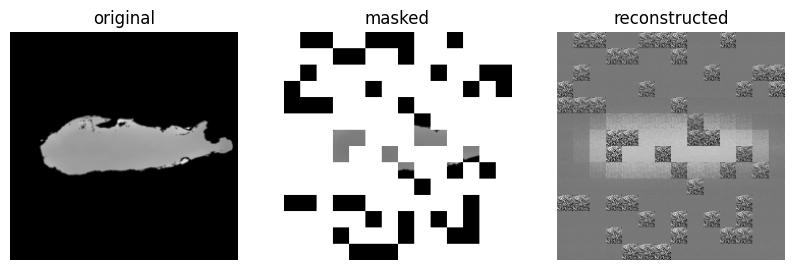

Epoch [6/100] Train Loss: 0.00812522


Epoch [6/100] Validation Loss: 0.00781045


Epoch [7/100] Train Loss: 0.00760357


Epoch [7/100] Validation Loss: 0.00753299


Epoch [8/100] Train Loss: 0.00732440


Epoch [8/100] Validation Loss: 0.00719893


Epoch [9/100] Train Loss: 0.00705233


Epoch [9/100] Validation Loss: 0.00669063


Epoch [10/100] Train Loss: 0.00636924


Epoch [10/100] Validation Loss: 0.00609782


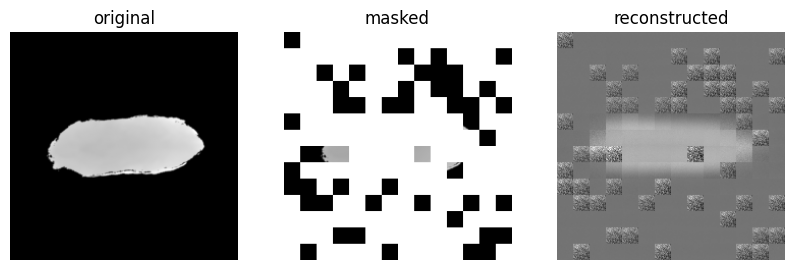

Epoch [11/100] Train Loss: 0.00595914


Epoch [11/100] Validation Loss: 0.00589759


Epoch [12/100] Train Loss: 0.00572035


Epoch [12/100] Validation Loss: 0.00574244


Epoch [13/100] Train Loss: 0.00557611


Epoch [13/100] Validation Loss: 0.00546022


Epoch [14/100] Train Loss: 0.00544455


Epoch [14/100] Validation Loss: 0.00534138


Epoch [15/100] Train Loss: 0.00532149


Epoch [15/100] Validation Loss: 0.00536878


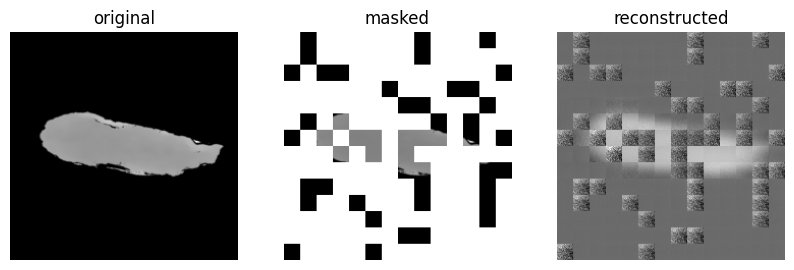

Epoch [16/100] Train Loss: 0.00521363


Epoch [16/100] Validation Loss: 0.00516491


Epoch [17/100] Train Loss: 0.00511934


Epoch [17/100] Validation Loss: 0.00534901


Epoch [18/100] Train Loss: 0.00505414


Epoch [18/100] Validation Loss: 0.00518381


Epoch [19/100] Train Loss: 0.00498834


Epoch [19/100] Validation Loss: 0.00501724


Epoch [20/100] Train Loss: 0.00492877


Epoch [20/100] Validation Loss: 0.00492365


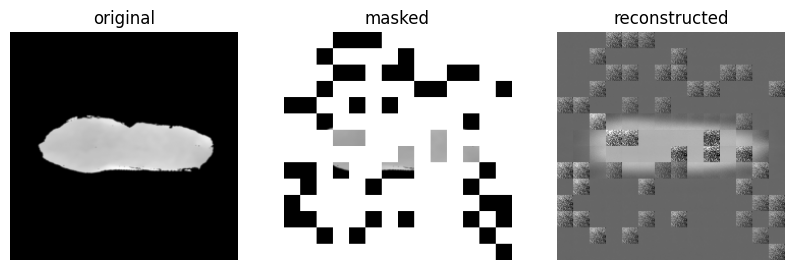

Epoch [21/100] Train Loss: 0.00488344


Epoch [21/100] Validation Loss: 0.00482466


Epoch [22/100] Train Loss: 0.00481632


Epoch [22/100] Validation Loss: 0.00479686


Epoch [23/100] Train Loss: 0.00477673


Epoch [23/100] Validation Loss: 0.00481130


Epoch [24/100] Train Loss: 0.00473778


Epoch [24/100] Validation Loss: 0.00471326


Epoch [25/100] Train Loss: 0.00467157


Epoch [25/100] Validation Loss: 0.00465834


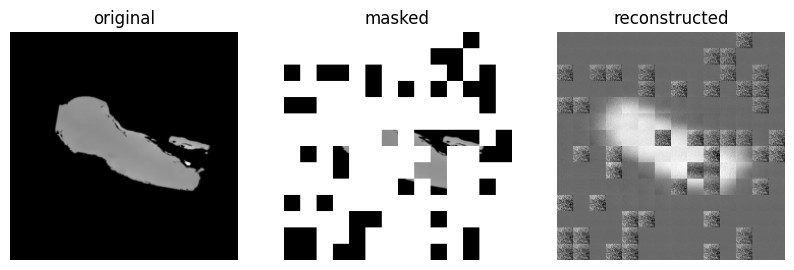

Epoch [26/100] Train Loss: 0.00463994


Epoch [26/100] Validation Loss: 0.00464534


Epoch [27/100] Train Loss: 0.00457881


Epoch [27/100] Validation Loss: 0.00454787


Epoch [28/100] Train Loss: 0.00454982


Epoch [28/100] Validation Loss: 0.00460870


Epoch [29/100] Train Loss: 0.00451136


Epoch [29/100] Validation Loss: 0.00449884


Epoch [30/100] Train Loss: 0.00446484


Epoch [30/100] Validation Loss: 0.00446113


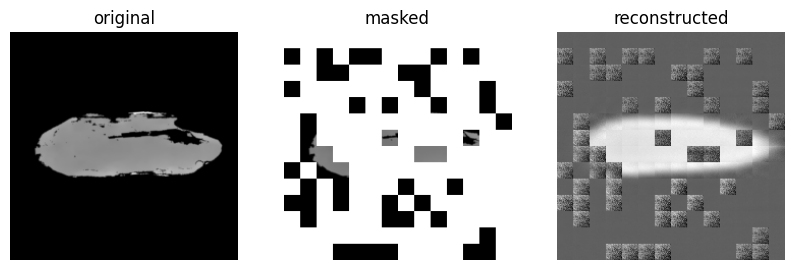

Epoch [31/100] Train Loss: 0.00443514


Epoch [31/100] Validation Loss: 0.00448666


Epoch [32/100] Train Loss: 0.00441359


Epoch [32/100] Validation Loss: 0.00447283


Epoch [33/100] Train Loss: 0.00437417


Epoch [33/100] Validation Loss: 0.00439264


Epoch [34/100] Train Loss: 0.00436818


Epoch [34/100] Validation Loss: 0.00438074


Epoch [35/100] Train Loss: 0.00434463


Epoch [35/100] Validation Loss: 0.00437736


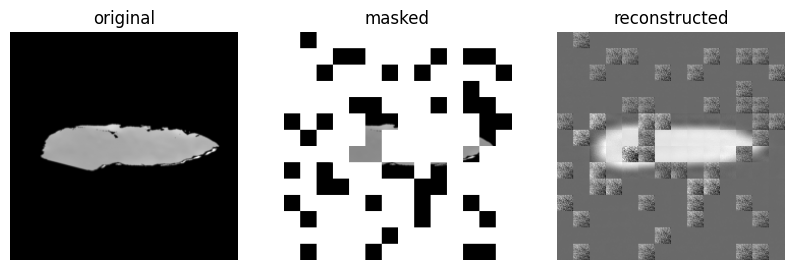

Epoch [36/100] Train Loss: 0.00431989


Epoch [36/100] Validation Loss: 0.00431653


Epoch [37/100] Train Loss: 0.00429610


Epoch [37/100] Validation Loss: 0.00432586


Epoch [38/100] Train Loss: 0.00427781


Epoch [38/100] Validation Loss: 0.00429745


Epoch [39/100] Train Loss: 0.00426549


Epoch [39/100] Validation Loss: 0.00427631


Epoch [40/100] Train Loss: 0.00425004


Epoch [40/100] Validation Loss: 0.00422123


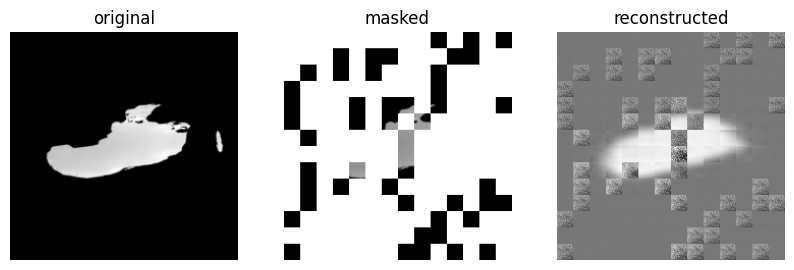

Epoch [41/100] Train Loss: 0.00422683


Epoch [41/100] Validation Loss: 0.00422716


Epoch [42/100] Train Loss: 0.00420670


Epoch [42/100] Validation Loss: 0.00425972


Epoch [43/100] Train Loss: 0.00418644


Epoch [43/100] Validation Loss: 0.00416876


Epoch [44/100] Train Loss: 0.00417631


Epoch [44/100] Validation Loss: 0.00416752


Epoch [45/100] Train Loss: 0.00415874


Epoch [45/100] Validation Loss: 0.00419459


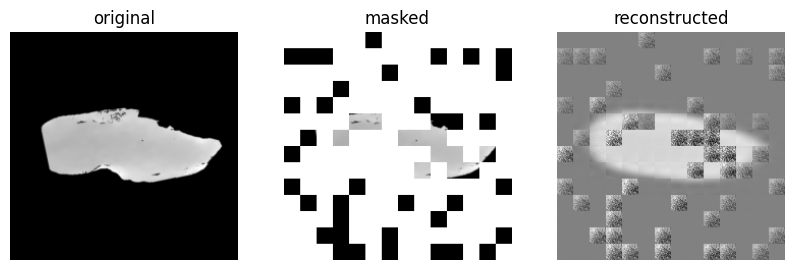

Epoch [46/100] Train Loss: 0.00413578


Epoch [46/100] Validation Loss: 0.00430777


Epoch [47/100] Train Loss: 0.00413943


Epoch [47/100] Validation Loss: 0.00415356


Epoch [48/100] Train Loss: 0.00410380


Epoch [48/100] Validation Loss: 0.00417224


Epoch [49/100] Train Loss: 0.00409918


Epoch [49/100] Validation Loss: 0.00414233


Epoch [50/100] Train Loss: 0.00408853


Epoch [50/100] Validation Loss: 0.00406161


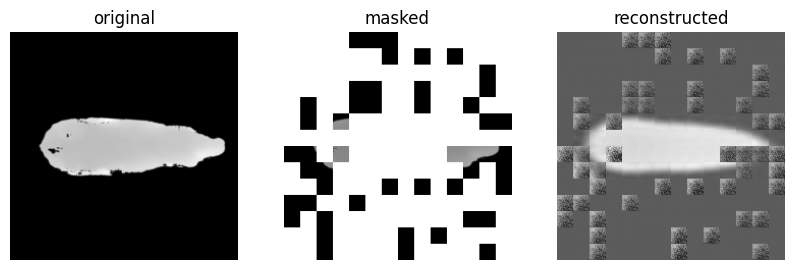

Epoch [51/100] Train Loss: 0.00407499


Epoch [51/100] Validation Loss: 0.00408486


Epoch [52/100] Train Loss: 0.00406562


Epoch [52/100] Validation Loss: 0.00406759


Epoch [53/100] Train Loss: 0.00406716


Epoch [53/100] Validation Loss: 0.00408185


Epoch [54/100] Train Loss: 0.00404351


Epoch [54/100] Validation Loss: 0.00402123


Epoch [55/100] Train Loss: 0.00404671


Epoch [55/100] Validation Loss: 0.00407504


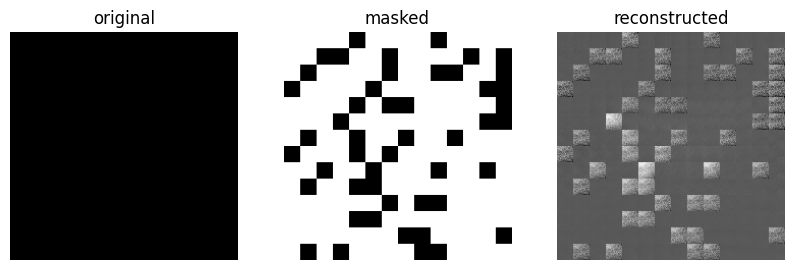

Epoch [56/100] Train Loss: 0.00402930


Epoch [56/100] Validation Loss: 0.00401972


Epoch [57/100] Train Loss: 0.00401378


Epoch [57/100] Validation Loss: 0.00402024


Epoch [58/100] Train Loss: 0.00401021


Epoch [58/100] Validation Loss: 0.00400997


Epoch [59/100] Train Loss: 0.00400855


Epoch [59/100] Validation Loss: 0.00403906


Epoch [60/100] Train Loss: 0.00399443


Epoch [60/100] Validation Loss: 0.00396536


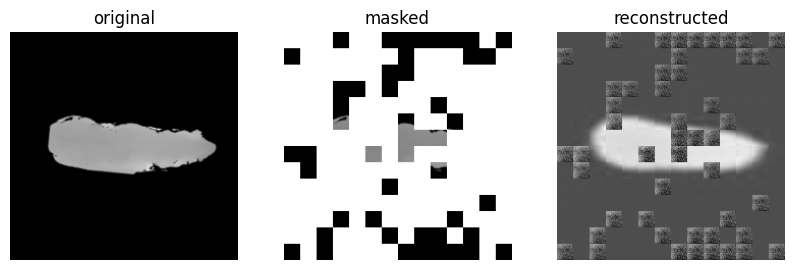

Epoch [61/100] Train Loss: 0.00399173


Epoch [61/100] Validation Loss: 0.00401157


Epoch [62/100] Train Loss: 0.00398542


Epoch [62/100] Validation Loss: 0.00398742


Epoch [63/100] Train Loss: 0.00396327


Epoch [63/100] Validation Loss: 0.00397619


Epoch [64/100] Train Loss: 0.00395555


Epoch [64/100] Validation Loss: 0.00395333


Epoch [65/100] Train Loss: 0.00394896


Epoch [65/100] Validation Loss: 0.00394238


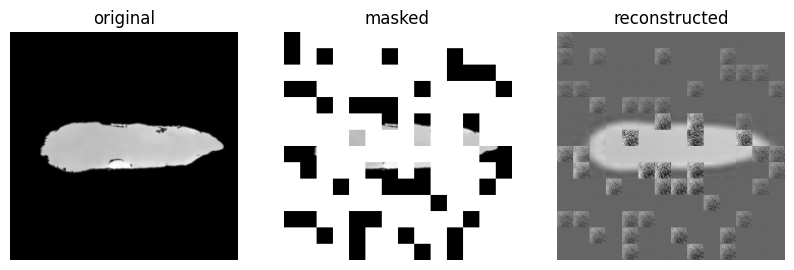

Epoch [66/100] Train Loss: 0.00393511


Epoch [66/100] Validation Loss: 0.00398477


Epoch [67/100] Train Loss: 0.00393248


Epoch [67/100] Validation Loss: 0.00392743


Epoch [68/100] Train Loss: 0.00391855


Epoch [68/100] Validation Loss: 0.00396004


Epoch [69/100] Train Loss: 0.00391149


Epoch [69/100] Validation Loss: 0.00393649


Epoch [70/100] Train Loss: 0.00391110


Epoch [70/100] Validation Loss: 0.00393842


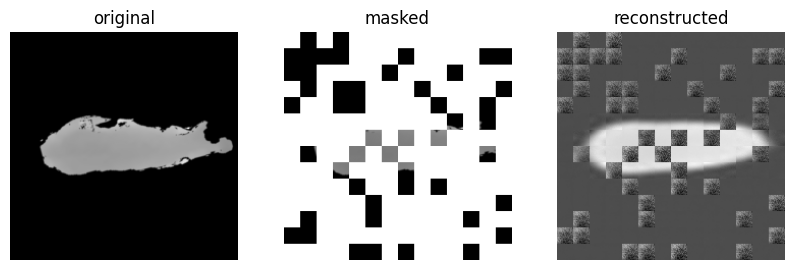

Epoch [71/100] Train Loss: 0.00391085


Epoch [71/100] Validation Loss: 0.00392553


Epoch [72/100] Train Loss: 0.00389311


Epoch [72/100] Validation Loss: 0.00391541


Epoch [73/100] Train Loss: 0.00389061


Epoch [73/100] Validation Loss: 0.00395680


Epoch [74/100] Train Loss: 0.00388955


Epoch [74/100] Validation Loss: 0.00388112


Epoch [75/100] Train Loss: 0.00386945


Epoch [75/100] Validation Loss: 0.00389598


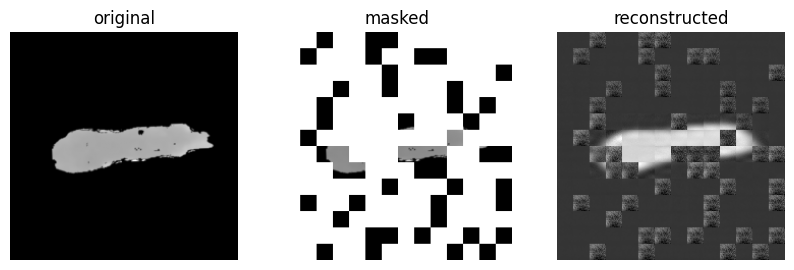

Epoch [76/100] Train Loss: 0.00386315


Epoch [76/100] Validation Loss: 0.00385542


Epoch [77/100] Train Loss: 0.00385761


Epoch [77/100] Validation Loss: 0.00389603


Epoch [78/100] Train Loss: 0.00385845


Epoch [78/100] Validation Loss: 0.00386947


Epoch [79/100] Train Loss: 0.00384803


Epoch [79/100] Validation Loss: 0.00384268


Epoch [80/100] Train Loss: 0.00384736


Epoch [80/100] Validation Loss: 0.00387200


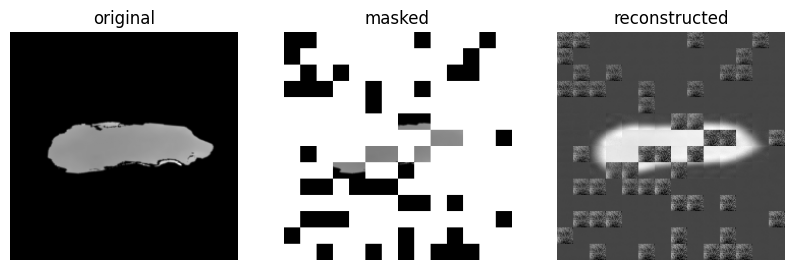

Epoch [81/100] Train Loss: 0.00383175


Epoch [81/100] Validation Loss: 0.00382944


Epoch [82/100] Train Loss: 0.00383645


Epoch [82/100] Validation Loss: 0.00385340


Epoch [83/100] Train Loss: 0.00383205


Epoch [83/100] Validation Loss: 0.00379337


Epoch [84/100] Train Loss: 0.00381935


Epoch [84/100] Validation Loss: 0.00378605


Epoch [85/100] Train Loss: 0.00380972


Epoch [85/100] Validation Loss: 0.00384428


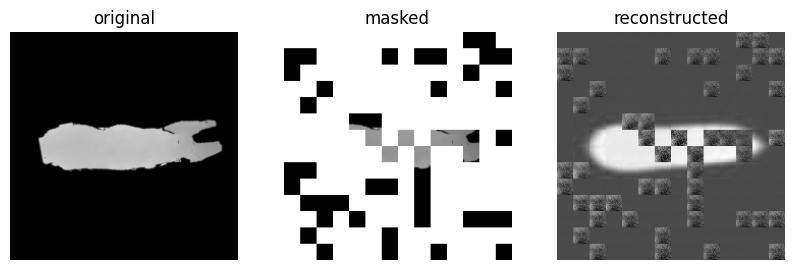

Epoch [86/100] Train Loss: 0.00381210


Epoch [86/100] Validation Loss: 0.00385212


Epoch [87/100] Train Loss: 0.00380368


Epoch [87/100] Validation Loss: 0.00382372


Epoch [88/100] Train Loss: 0.00379861


Epoch [88/100] Validation Loss: 0.00383106


Epoch [89/100] Train Loss: 0.00379869


Epoch [89/100] Validation Loss: 0.00384009


Epoch [90/100] Train Loss: 0.00378820


Epoch [90/100] Validation Loss: 0.00383631


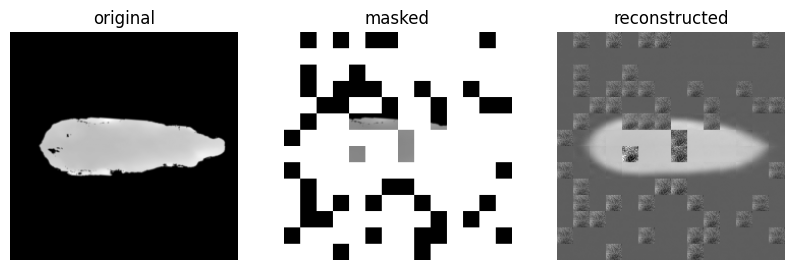

Epoch [91/100] Train Loss: 0.00377232


Epoch [91/100] Validation Loss: 0.00381586


Epoch [92/100] Train Loss: 0.00379081


Epoch [92/100] Validation Loss: 0.00382212


Epoch [93/100] Train Loss: 0.00376089


Epoch [93/100] Validation Loss: 0.00376600


Epoch [94/100] Train Loss: 0.00376776


Epoch [94/100] Validation Loss: 0.00378471


Epoch [95/100] Train Loss: 0.00376742


Epoch [95/100] Validation Loss: 0.00374022


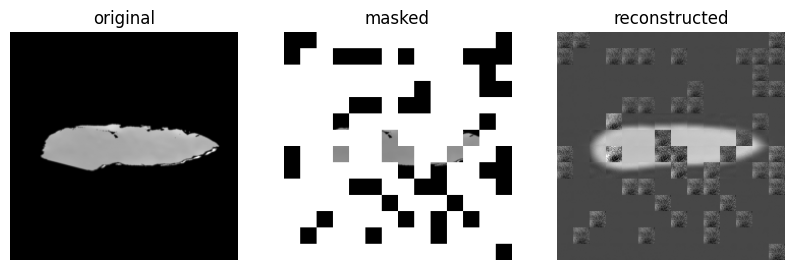

Epoch [96/100] Train Loss: 0.00375387


Epoch [96/100] Validation Loss: 0.00378942


Epoch [97/100] Train Loss: 0.00375266


Epoch [97/100] Validation Loss: 0.00377087


Epoch [98/100] Train Loss: 0.00375901


Epoch [98/100] Validation Loss: 0.00374953


Epoch [99/100] Train Loss: 0.00374228


Epoch [99/100] Validation Loss: 0.00374163


Epoch [100/100] Train Loss: 0.00373942


Epoch [100/100] Validation Loss: 0.00372792


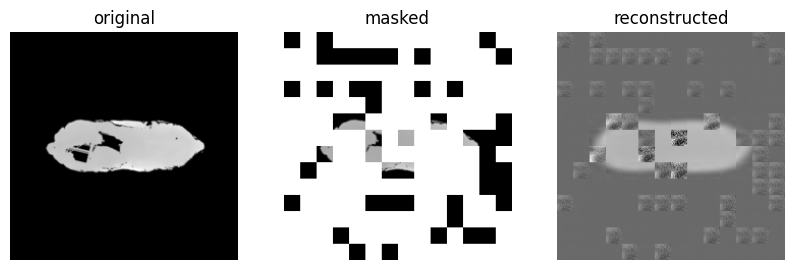

Training complete!


In [8]:

# Training loop
num_epochs = 100


for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    # Training loop with progress bar
    train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Train", leave=False)
    for images in train_loop:
        images = images.to(device)  # Move images to GPU
        
        optimizer.zero_grad()
        loss, _, _ = model(images)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_loop.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_loss:.8f}")
    
    # Validation loop with progress bar
    model.eval()
    val_loss = 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Val", leave=False)
    with torch.no_grad():
        for images in val_loop:
            images = images.to(device)
            loss, _, _ = model(images)
            val_loss += loss.item()
            val_loop.set_postfix(loss=loss.item())
            
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.8f}")
    
    # plot each 5 epoch

    if (epoch+1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            # select random batch
            images = next(iter(val_loader))
            images = images.to(device)

            _, pred, masks = model(images)

            # Split the images into patches
            patches = split_images(images, patch_size=16)

            masked_images = apply_mask_to_patches(images, patches, masks, patch_size=16)
            
            # unpatch the pred
            recon_images = model.unpatchify(pred)

            visualize_image(images, masked_images, recon_images)
            

        
print("Training complete!")

In [14]:
#save model

torch.save(model.state_dict(), "./checkpoints/mae_checkpoint.pth")

In [10]:
# load model

# checkpoint = torch.load("./checkpoints/mae_checkpoint.pth")
# model.load_state_dict(checkpoint)

In [11]:

# select a batch from validation set

images = next(iter(val_loader)).to(device)

model.eval()

with torch.no_grad():
    _, recon_images, masks = model(images)


# Split the images into patches
patches = split_images(images, patch_size=16)

In [12]:
recon_images_unpatch = model.unpatchify(recon_images)

In [13]:
# Aplicar máscara às imagens
masked_images = apply_mask_to_patches(images, patches, masks, patch_size = 16)


# Visualizar
visualize_images(images, masked_images,recon_images_unpatch)

NameError: name 'visualize_images' is not defined